## Marketing Analytics: RFM & K-Means Clustering

In this notebook, we will be analyzing an online retail sales dataset and use K-Means Clustering to do customer segmentation based on calculated RFM values. This online retail sales <a href ="eight month period. https://www.kaggle.com/vijayuv/onlineretail">kaggle dataset</a> contains the sales transactions of an online UK retail company over a 8 month period.

In [1]:
# import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

In [2]:
# load data from csv
path = 'datasets/OnlineRetail.csv'
df = pd.read_csv(path, encoding = 'cp1252')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# check field types
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [4]:
# convert datefield to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'] = df['InvoiceDate'].dt.date

In [5]:
# check for null values
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Missing values found in Description, CustomerID. If Product description is empty, it is alright, but missing customerID values will affect the accuracy of the data for customer segmentation.

In [6]:
# drop missing values 
df.dropna(inplace = True)
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


Negative quantity and unit price indicates customer returns, drop these values

In [8]:
# drop negative values
col = df[(df['Quantity'] <= 0)].index
df.drop(col, inplace = True)

col = df[df['UnitPrice'] <= 0].index
df.drop(col, inplace = True)

df.describe()

,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453
std,179.331775,22.097877,1713.141560
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [9]:
df['Country'].value_counts()

United Kingdom          354321
Germany                   9040
France                    8341
EIRE                      7236
Spain                     2484
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1462
Australia                 1182
Norway                    1071
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45
Lithuani

In [10]:
# We will select UK as the country for customer segmentation analysis
uk_df = df[df.Country =="United Kingdom"]
uk_df.Country.value_counts()

United Kingdom    354321
Name: Country, dtype: int64

In [11]:
# Calculate revenue per CustomerID 
uk_df['revenue']= uk_df['UnitPrice']*uk_df['Quantity']
uk_df.head()

C:\Users\cszes\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


### Calculate Recency, Frequency, Monetary Values
* Recency refers to the no. of days since the last purchase 
* Frequency refers to the no. of transactions in the last 12 months
* Monetary Value refers to the total spend in the last 12 months

In [43]:
# create a reference date for recency
reference_date = max(uk_df['InvoiceDate'] + datetime.timedelta(days=1))
print('Min Invoice Date: {}, Max Invoice Date: {}\n Reference Date: {}'. format(min(uk_df['InvoiceDate']),max(uk_df['InvoiceDate']), reference_date))

# aggregate data on customer level
uk_rfm = uk_df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo' : 'count',
    'revenue': 'sum'
}).reset_index()

uk_rfm.rename(columns = {
    'InvoiceDate': 'Recency',
    'InvoiceNo' : 'Frequency',
    'revenue': 'MonetaryValue'}, 
    inplace = True)

uk_rfm.head()

Min Invoice Date: 2010-12-01, Max Invoice Date: 2011-12-09
 Reference Date: 2011-12-10


,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,326,1,77183.60
1,12747.0,3,103,4196.01
2,12748.0,1,4595,33719.73
3,12749.0,4,199,4090.88
4,12820.0,4,59,942.34


In [44]:
# Assigning RFM scores
# Recency score- higher recency score given to latest purchase
r_labels = range(4,0,-1) 
uk_rfm['R'] = pd.qcut(uk_rfm['Recency'], 4, labels= r_labels)

# Frequency score- higher frequency score given to higher purchase
f_labels = range(1,5) 
uk_rfm['F'] = pd.qcut(uk_rfm['Frequency'], 4, labels= f_labels)

# MonetaryValue score- higher mv score given to higher purchase
m_labels = range(1,5) 
uk_rfm['M'] = pd.qcut(uk_rfm['MonetaryValue'], 4, labels= m_labels)
uk_rfm.head()

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M
0,12346.0,326,1,77183.60,1,1,4
1,12747.0,3,103,4196.01,4,4,4
2,12748.0,1,4595,33719.73,4,4,4
3,12749.0,4,199,4090.88,4,4,4
4,12820.0,4,59,942.34,4,3,3


In [48]:
# Aggregate the total score across R,F,M in a new col
uk_rfm['RFMscore'] = uk_rfm[['R','F','M']].sum(axis=1)
uk_rfm.drop(columns=['R','F','M'], axis=1, inplace=True)
uk_rfm.describe()

,CustomerID,Recency,Frequency,MonetaryValue,RFMscore
count,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000
mean,15562.059694,92.742092,90.388010,1864.385601,7.492092
std,1576.594671,99.533485,217.808385,7482.817477,2.823721
min,12346.000000,1.000000,1.000000,3.750000,3.000000
25%,14208.750000,18.000000,17.000000,300.280000,5.000000
50%,15569.500000,51.000000,41.000000,652.280000,7.000000
75%,16913.250000,143.000000,99.250000,1576.585000,10.000000
max,18287.000000,374.000000,7847.000000,259657.300000,12.000000


### Visualizing RFM distribution

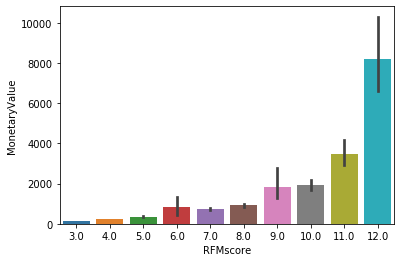

In [46]:
sns.barplot(x='RFMscore', y='MonetaryValue', data=uk_rfm)

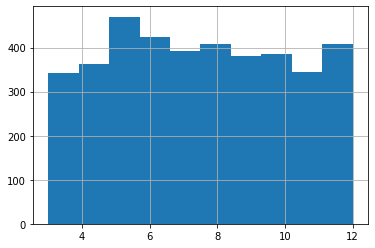

In [47]:
uk_rfm['RFMscore'].hist()

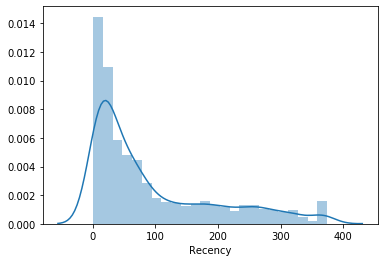

In [49]:
sns.distplot(uk_rfm['Recency'])
plt.show()

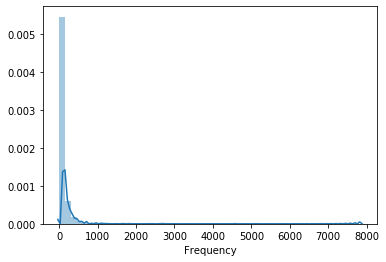

In [50]:
sns.distplot(uk_rfm['Frequency'])
plt.show()

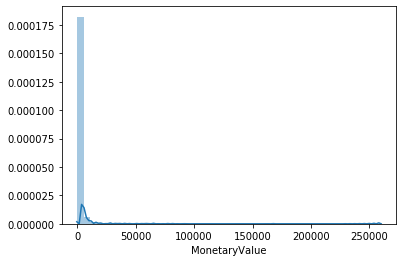

In [51]:
sns.distplot(uk_rfm['MonetaryValue'])
plt.show()

From the above distribution plots, frequency and monetary value are highly skewed. To bring the data to a similar range we have to do log transformation and standardization. 

In [52]:
# log transformation to unskew the data
# create new df to store the log transformed data
# drop CustomerID since its not needed
uk_rfm_log = pd.DataFrame(uk_rfm)
uk_rfm_log.drop(columns=['CustomerID'], axis=1, inplace=True)
uk_rfm_log['Recency'] = np.log(uk_rfm_log['Recency'])
uk_rfm_log['Frequency'] = np.log(uk_rfm_log['Frequency'])
uk_rfm_log['MonetaryValue'] = np.log(uk_rfm_log['MonetaryValue'])

[[ 1.43842824 -2.73653753  3.77775111 -0.52848076]
 [-1.95355462  0.7267276   1.44244588  1.59664617]
 [-2.74840262  3.5647498   3.11365765  1.59664617]
 [-1.74541611  1.21884326  1.42209736  1.59664617]
 [-1.74541611  0.31037055  0.24472295  0.88827053]]


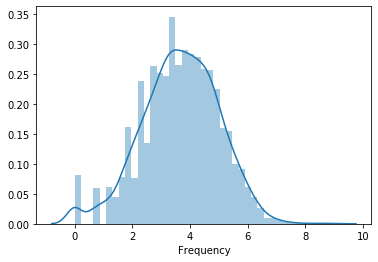

In [55]:
sns.distplot(uk_rfm_log['Frequency'])
plt.show()

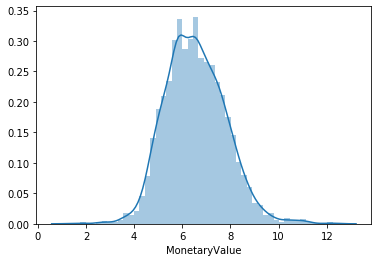

In [54]:
sns.distplot(uk_rfm_log['MonetaryValue'])
plt.show()

Distribution plots for frequency and monetary value are now more evenly distributed

In [ ]:
#standardize the data and bring it to the same scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(uk_rfm_log)
uk_rfm_normalized = scaler.transform(uk_rfm_log)
print(uk_rfm_normalized[0:5,:])

Now are dataset is ready for K-Means clustering

## K-Means Clustering
### Using the elbow method to find the optimal no. of K clusters

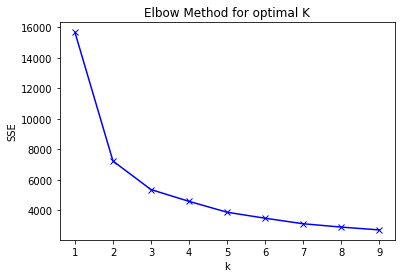

In [70]:
# import libaries
from sklearn.cluster import KMeans

SSE = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, random_state= 10)
    km = km.fit(uk_rfm_normalized)
    SSE.append(km.inertia_)
    
plt.plot(K, SSE, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method for optimal K')
plt.show()

Optimal no. of clusters is 2

In [60]:
# Use k=2 clusters and run K means 
kmeans = KMeans(n_clusters=2, random_state=10)
kmeans.fit_predict(uk_rfm_normalized)
cluster_labels = kmeans.labels_

# assign cluster to original uk_rfm df
uk_Kmeans = uk_rfm.assign(Cluster=cluster_labels)

## K-Means Cluster Results

In [64]:
uk_Kmeans.head()

,CustomerID,Recency,Frequency,MonetaryValue,RFMscore,Cluster
0,12346.0,326,1,77183.60,6.0,0
1,12747.0,3,103,4196.01,12.0,1
2,12748.0,1,4595,33719.73,12.0,1
3,12749.0,4,199,4090.88,12.0,1
4,12820.0,4,59,942.34,10.0,1


In [68]:
uk_Kmeans.groupby('Cluster').agg({ 
    'Recency': 'mean', 
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'], }).round(0) 

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         145.0      23.0         462.0  2094
1          33.0     167.0        3472.0  1826

Cluster 0 has higher average recency values than Cluster 1 but lower frequency and monetary value scores, indicating this customer group is likely to be new customers shopping on the platform. 

Cluster 1 has lower recency values than Cluster 0 but higher frequency and monetary value scores, indicating this customer group is likely to be their regular customers and higher spending power. However, what is the explaination for lower recency values if purchase frequency is higher?